In [1]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
hospital_file = '..//YAIB-cohorts/data/mortality24/eicu/above2000.txt'
df = pd.read_csv(hospital_file, header=None)

In [3]:
n = 12
hospital_ids = df[0].values[:n]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

## Section 1: Data Addition for 1 Hospital: 

In [54]:
sem_ratio = np.sqrt(5)
hos=443
# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
hos_ind = hospital_dict[hos]
model = "LogisticRegression"
n_avg = np.load(f"results/sequential-n/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz")
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz")
data_addition_avg = np.load(f"results/add_data/{model}-avg.npz")
data_addition_std = np.load(f"results/add_data/{model}-std.npz")

with open('results/add_data/num_addition.pk', 'rb') as handle:
    addition_dict = pickle.load(handle)

In [55]:
plot_df = pd.DataFrame.from_dict(n_avg['AUC'].item(), orient='index', columns=['AUC'])
std_df = pd.DataFrame.from_dict(n_std['AUC'].item(), orient='index', columns=['std'])
plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

In [56]:
for i in range(len(hospital_ids)): 
    if hospital_ids[i] != hos: 
        new_hospital = {
            'n': addition_dict[hospital_ids[i]] + 2000, 
            'AUC': data_addition_avg['AUC'][:, hos_ind][i], 
            'std': data_addition_std['AUC'][:, hos_ind][i],
            'train_hospital': hospital_ids[i]
            }
        
        new_df.loc[len(new_df)] = new_hospital
        prev_result = new_df.loc[5].to_dict()
        prev_result['train_hospital'] = hospital_ids[i] 
        prev_result['std'] = 0
        new_df.loc[len(new_df)] = prev_result

new_df['sem'] = new_df['std']/sem_ratio

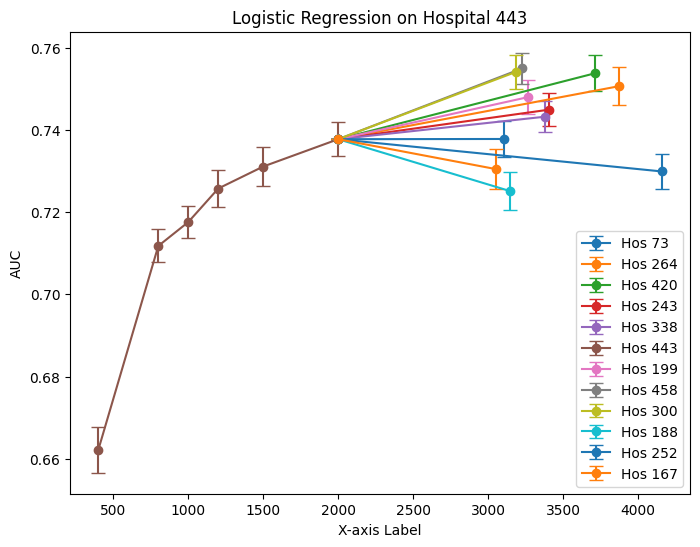

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars
for i in range(len(hospital_ids)): 
    hos_df = new_df[new_df['train_hospital'] == hospital_ids[i]]
    ax.errorbar(x=hos_df['n'],
                y=hos_df['AUC'],
                yerr=[hos_df['sem'] ,hos_df['sem']],
                fmt='o-',
                capsize=5,
                label=f'Hos {hospital_ids[i]}')

# Set labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('AUC')
ax.set_title(f'Logistic Regression on Hospital {hos}')

# Show the legend
ax.legend()

# Display the plot
plt.show()

## Section 2: Distribution Shift Across All Hospitals

Text(0.5, 0.98, 'LogisticRegression Train-Test AUC drop across hospitals')

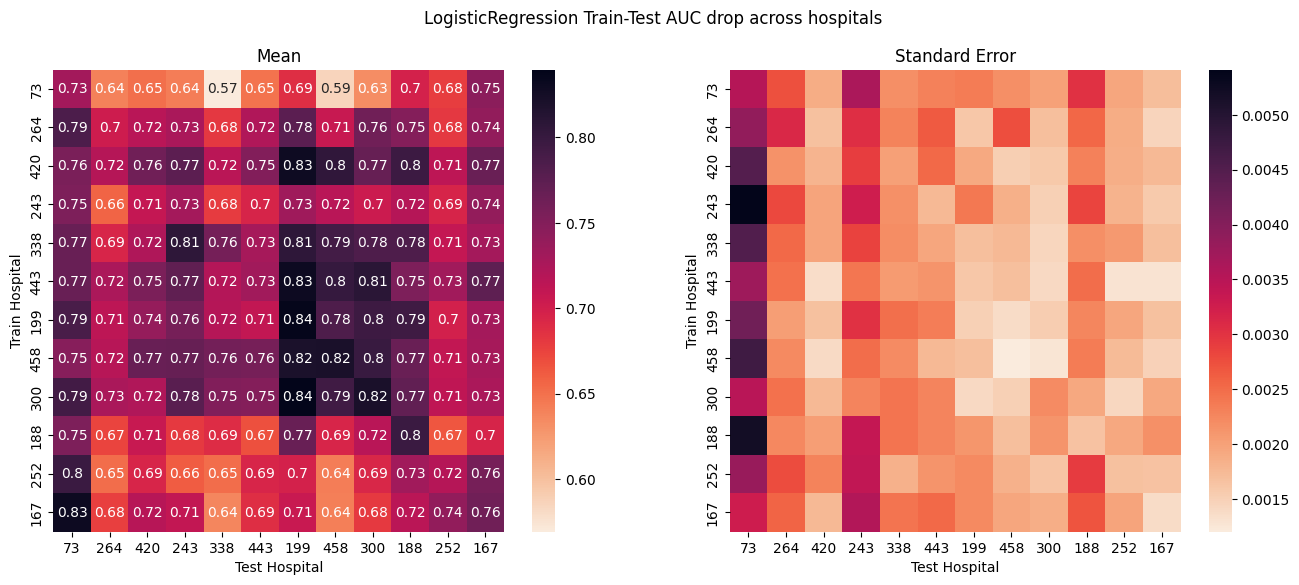

In [60]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

sns.heatmap(dist_shift_avg[metric], annot=True, cmap="rocket_r", ax=axes[0], 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")

sns.heatmap(dist_shift_std[metric]/np.sqrt(25), fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("Standard Error")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

Text(0.5, 1.0, 'LogisticRegression AUC Change Between Train and Test Hospitals')

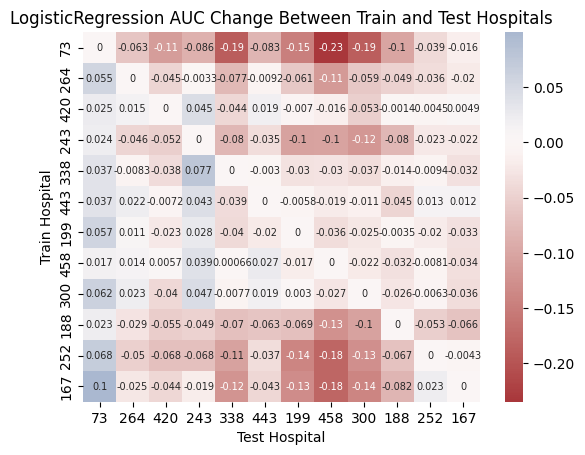

In [61]:
# Differences
diff = dist_shift_avg[metric] - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
sns.heatmap(diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=hospital_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

Text(0.5, 1.0, 'LSTM vs. LR  Correlation')

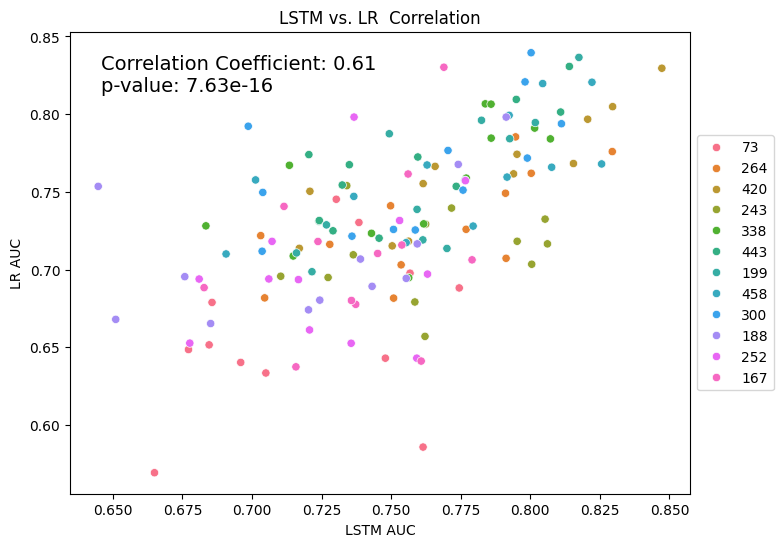

In [70]:
LR = np.load('results/dist_shift/LogisticRegression-n1500-avg.npz')
LGBM = np.load('results/dist_shift/LGBMClassifier-n1500-avg.npz')
# TODO: change to n1500
LSTM = np.load('results/dist_shift/LSTM-avg.npz')

metric = 'AUC'
plot_df = pd.DataFrame()
plot_df['LR'] = LR[metric].flatten()
plot_df['LGBM'] = LGBM[metric].flatten()
plot_df['LSTM'] = LSTM[metric].flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids, repeats=len(hospital_ids))
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids.reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

clf1 = 'LSTM'
clf2 = 'LR'
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x=clf1, y=clf2, hue='train_hospital')
corr_coef, p_value = pearsonr(plot_df[clf1], plot_df[clf2])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(f'{clf1} {metric}')
ax.set_ylabel(f'{clf2} {metric}')
ax.set_title(f'{clf1} vs. {clf2}  Correlation')

In [66]:
metric = 'AUC'
keys_gender = [(f'{metric}', 'All'), 
               (f'gender0_{metric}_TEST', 'Female'),  
                (f'gender1_{metric}_TEST', 'Male')]
keys_race = [(f'{metric}', 'All'),
        (f'race0_{metric}_TEST', 'Asian'), 
        (f'race1_{metric}_TEST', 'Black'), 
        (f'race2_{metric}_TEST', 'Other'),
        (f'race3_{metric}_TEST', 'White')]

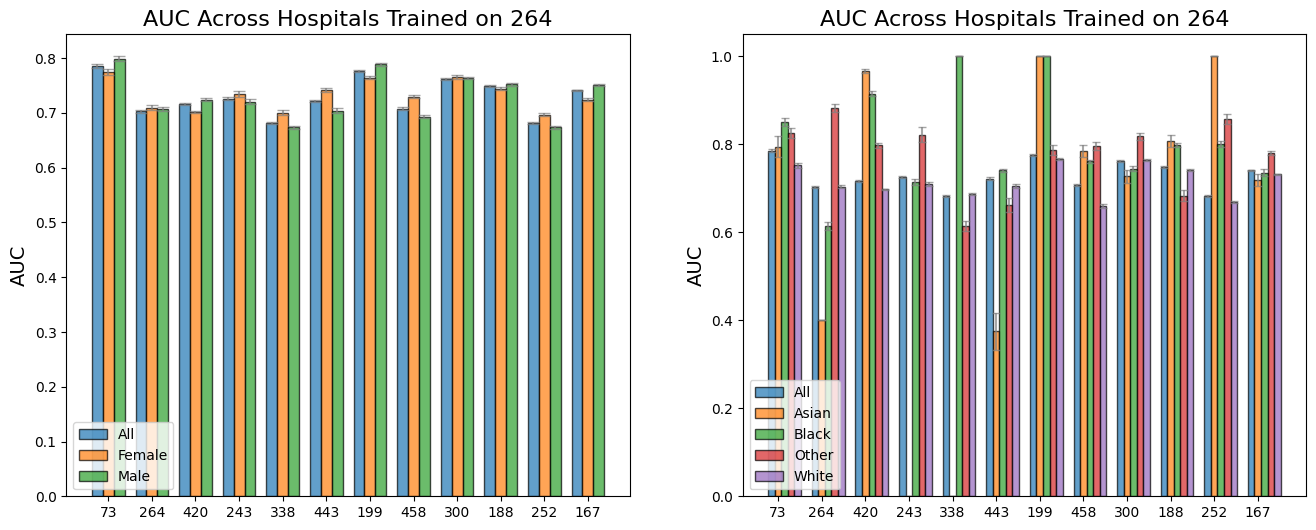

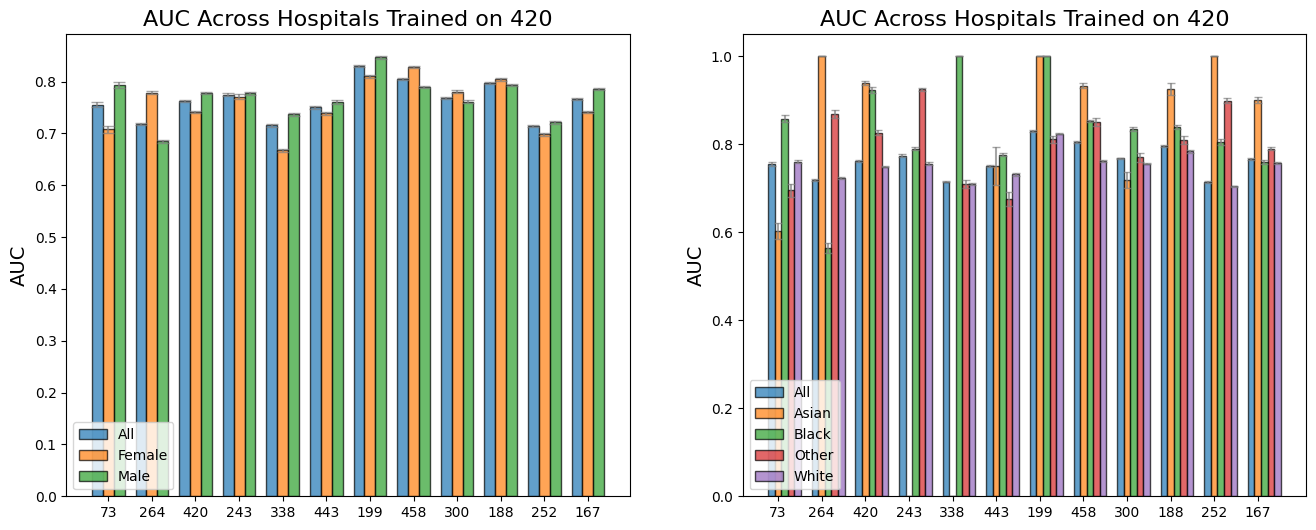

In [69]:
# for train hospital 73
for train_hid in [1, 2]:  
    # Plot the bars
    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    # Set the bar positions and width
    bar_positions = np.arange(len(hospital_ids))
    bar_width = 0.25
    
    ax = axes[0]
    for i, (key, label) in enumerate(keys_gender): 
        auc_values = dist_shift_avg[key][train_hid]
        std = dist_shift_std[key][train_hid]
        sem = std/np.sqrt(25)
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label)
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[sem, sem], 
                                 capsize=4, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=14)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=16)
        ax.legend()
    
    bar_width = 0.15
    ax = axes[1]
    for i, (key, label) in enumerate(keys_race): 
        auc_values = dist_shift_avg[key][train_hid]
        std = dist_shift_std[key][train_hid]
        sem = std/np.sqrt(25)
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label)
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[sem, sem], 
                                 capsize=3, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=14)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=16)
        ax.legend()
        
        # # Adjust the y-axis limits
        
        # # Add value labels on top of the bars
        # for bar, auc in zip(bars, auc_values):
        #     height = bar.get_height() +0.04
        #     print(height)
        #     ax.annotate(f'{auc:.2f}',
        #                 xy=(bar.get_x() + bar.get_width() / 2, height),
        #                 xytext=(0, 3),
        #                 textcoords="offset points",
        #                 ha='center', va='bottom', fontsize=10)

## Section 3: Data Addition

In [70]:
# load required data 
# TODO: Change to n1500
model = 'LogisticRegression'
data_addition_avg = np.load(f"results/add_data/{model}-n1500-avg.npz")
data_addition_std = np.load(f"results/add_data/{model}-n1500-std.npz")
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz")

Text(0.5, 0.98, 'LogisticRegression Train-Test AUC drop across hospitals')

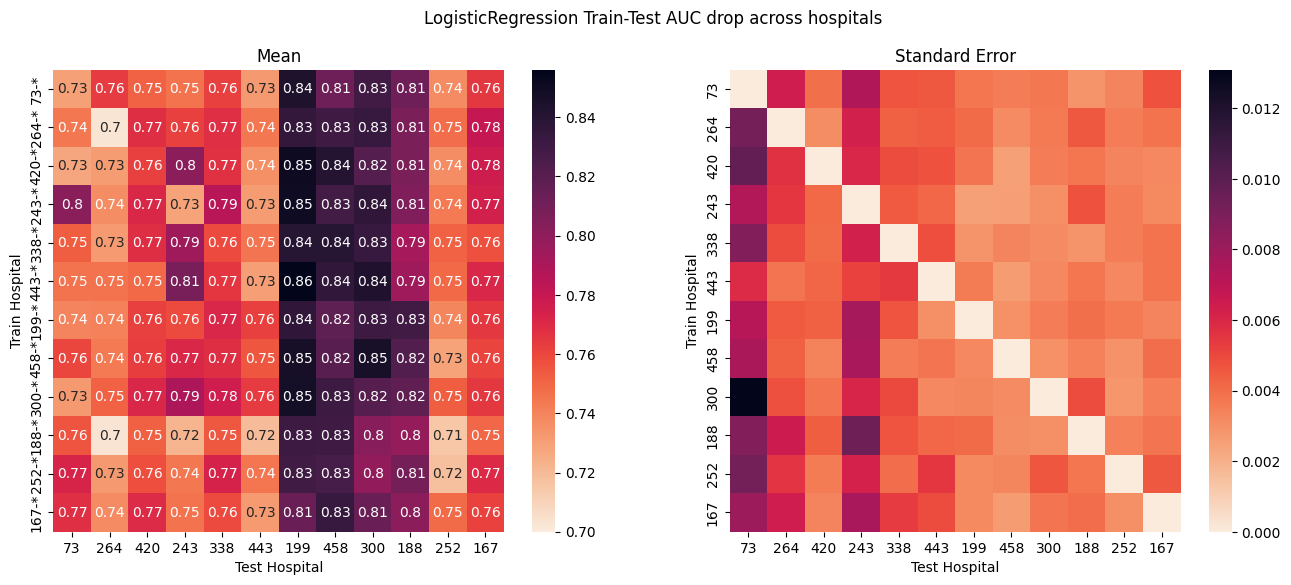

In [71]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]
plot_mat = data_addition_avg[metric] + np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")

sns.heatmap(data_addition_std[metric]/sem_ratio, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("Standard Error")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

Text(0.5, 1.0, 'LogisticRegression AUC Change Between Train and Test Hospitals')

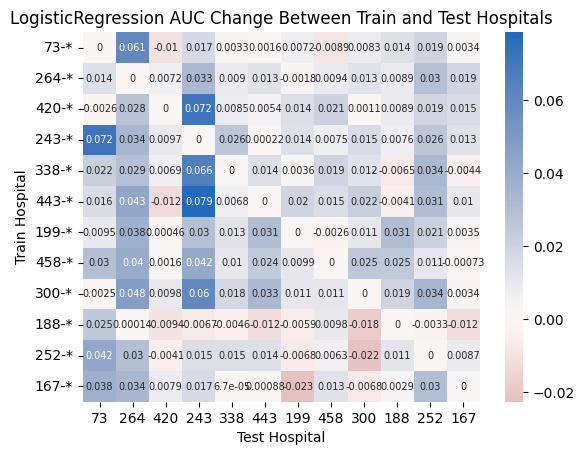

In [72]:
addition_diff = plot_mat - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
sns.heatmap(addition_diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=train_test_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

In [78]:
plot_df['OOD'] = diff.flatten()
plot_df['Data-Addition'] = addition_diff.flatten()

Text(0.5, 1.0, 'LogisticRegression OOD vs. Data-Addition Correlation')

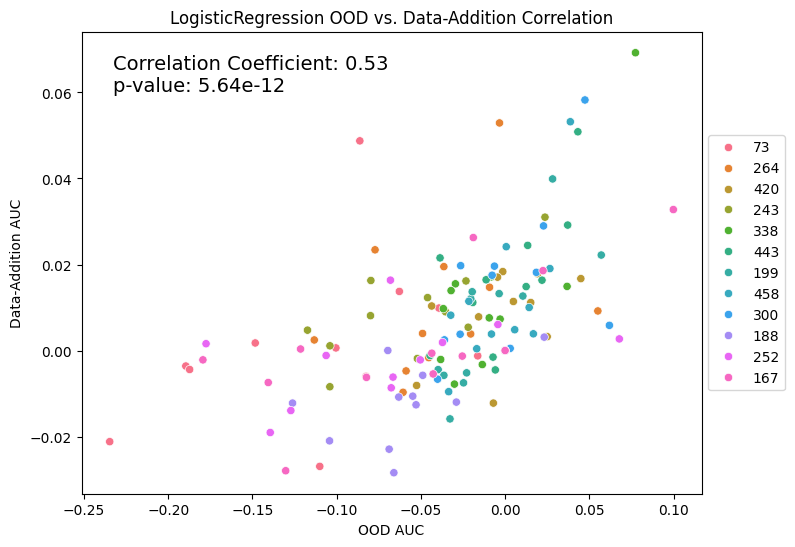

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='OOD', y='Data-Addition', hue='train_hospital')
corr_coef, p_value = pearsonr(plot_df['OOD'], plot_df['Data-Addition'])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(f'OOD {metric}')
ax.set_ylabel(f'Data-Addition {metric}')
ax.set_title(f'{model} OOD vs. Data-Addition Correlation')

### Section 2B/3B: Correlation

In [75]:
# load data
metric = 'AUC'
LR_AUC = np.load('results/dist_shift/LogisticRegression-AUC-n1500-diff-avg.npz')[metric]
LGBM_AUC = np.load('results/dist_shift/LGBMClassifier-AUC-n1500-diff-avg.npz')[metric]
LSTM_AUC = np.load('results/dist_shift/LSTM-AUC-n1500-diff-avg.npz')[metric]
# TODO: Add LGBM and LSTM for 1500 
with open('results/add_data/LogisticRegression-AUC-n1500-diff-avg.npy', 'rb') as f: 
    LR_ADD_AUC = np.load(f)
 
# KL load
with open('results/distances/KL-ratio-x-true.npy', 'rb') as f: 
    ratio_x = np.load(f)
with open('results/distances/KL-ratio-xy-true.npy', 'rb') as f: 
    ratio_xy = np.load(f)

# KL load
with open('results/distances/score-x.npy', 'rb') as f: 
    score_x = np.load(f)
with open('results/distances/score-xy.npy', 'rb') as f: 
    score_xy = np.load(f)
    
with open('results/distances/KL-ratio-addition-x.npy', 'rb') as f: 
    add_ratio_x = np.load(f)
with open('results/distances/KL-ratio-addition-xy.npy', 'rb') as f: 
    add_ratio_xy = np.load(f)

with open("results/distances/distance_metrics.pk", 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)



In [61]:
plot_df = pd.DataFrame()
plot_df['LR'] = LR_AUC.flatten()
plot_df['LGBM'] = LGBM_AUC.flatten()
plot_df['LSTM'] = LSTM_AUC.flatten()

plot_df['LR-ADD'] = LR_ADD_AUC.flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids[:n], repeats=n)
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids[:n].reshape(-1, 1), repeats=n, axis=1).T.flatten()
plot_df['test_hospital'] = plot_df['test_hospital'].astype(str)
plot_df['KL_ratio_x'] = ratio_x.flatten() 
plot_df['KL_ratio_xy'] = ratio_xy.flatten() 
plot_df['score_x'] = score_x.flatten() 
plot_df['score_xy'] = score_xy.flatten() 
plot_df['KL_add_ratio_x'] = add_ratio_x.flatten() 
plot_df['KL_add_ratio_xy'] = add_ratio_xy.flatten() 

for key in data.keys(): 
    dist = data[key]
    dist_pairwise = np.zeros((len(hospital_ids), len(hospital_ids)))
    for i, j in dist.keys(): 
        dist_pairwise[hospital_dict[i], hospital_dict[j]] = dist[(i, j)]
    plot_df[key] = dist_pairwise.flatten()

# remove zeros
plot_df = plot_df.drop(np.arange(0, n)*(n+1))

In [69]:
plot_df[plot_df['test_hospital']=='199'].sort_values(by='score_xy')

,LR,LGBM,LSTM,LR-ADD,train_hospital,test_hospital,KL_ratio_x,KL_ratio_xy,score_x,score_xy,KL_add_ratio_x,KL_add_ratio_xy,mort_dist,racemort_dist,agemort_dist,sexmort_dist,ct_dist,age_dist,sex_dist,race_dist
102,0.003005,-0.033742,-0.017185,0.000498,300,199,0.602932,0.602058,0.589448,0.589306,-0.325042,-0.313937,0.313175,0.233980,0.065290,0.013906,0.245077,0.053361,0.037518,0.154197
90,-0.016843,-0.025222,-0.013017,0.000415,458,199,0.727539,0.725035,0.593103,0.592598,-0.326016,-0.323279,0.403688,0.256272,0.099972,0.047444,0.557108,0.067647,0.046288,0.443173
138,-0.130279,-0.107446,-0.038400,-0.027953,167,199,0.829207,0.830580,0.617385,0.617914,-0.296681,-0.306531,0.299306,0.212112,0.057231,0.029963,0.377056,0.060890,0.002364,0.313802
54,-0.030090,-0.080116,-0.031570,-0.007810,338,199,0.825320,0.825389,0.638503,0.638686,-0.321176,-0.322937,0.225232,0.149018,0.054960,0.021254,0.077893,0.024987,0.007166,0.045740
30,-0.006967,-0.026581,0.029798,-0.012225,420,199,0.973197,0.970331,0.653867,0.653525,-0.211741,-0.235360,0.353632,0.235837,0.080466,0.037329,0.194967,0.045553,0.023610,0.125804
42,-0.104062,-0.148617,-0.012156,-0.008421,243,199,1.122970,1.129942,0.652415,0.653830,-0.303486,-0.317965,0.495629,0.353305,0.089822,0.052503,0.470136,0.031533,0.009879,0.428725
18,-0.060602,-0.089993,0.011987,-0.009715,264,199,1.084251,1.079237,0.661419,0.660439,-0.247032,-0.187645,0.389096,0.313224,0.051112,0.024760,0.186480,0.042007,0.061738,0.082736
114,-0.068852,-0.040106,-0.043357,-0.022934,188,199,1.121623,1.119531,0.664831,0.664518,-0.182192,-0.288631,0.358163,0.277510,0.064689,0.015964,0.391173,0.041154,0.040492,0.309527
66,-0.005813,-0.040056,-0.003437,-0.004512,443,199,1.789076,1.791594,0.687054,0.687204,-0.239701,-0.239617,0.339476,0.253972,0.069022,0.016482,0.927098,0.178319,0.015015,0.733765
126,-0.139444,-0.095806,-0.054404,-0.019066,252,199,1.678891,1.696442,0.725441,0.727499,-0.281980,-0.271665,0.204920,0.074993,0.088466,0.041460,0.130996,0.050313,0.002318,0.078366


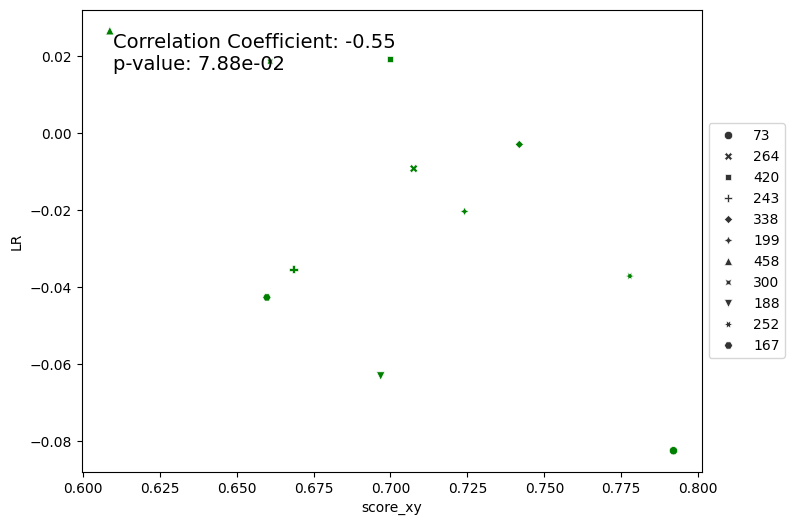

In [66]:
clf = 'LR'
dist = 'score_xy'

selected_df = plot_df[plot_df['test_hospital']=='443']
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=selected_df, y=clf, x=dist, style='train_hospital', c='g')
corr_coef, p_value = pearsonr(selected_df[clf], selected_df[dist])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

In [17]:
plot_df.keys()

Index(['LR', 'LGBM', 'LSTM', 'LR-ADD', 'train_hospital', 'test_hospital',
       'KL_ratio_x', 'KL_ratio_xy', 'score_x', 'score_xy', 'KL_add_ratio_x',
       'KL_add_ratio_xy', 'mort_dist', 'racemort_dist', 'agemort_dist',
       'sexmort_dist', 'ct_dist', 'age_dist', 'sex_dist', 'race_dist'],
      dtype='object')

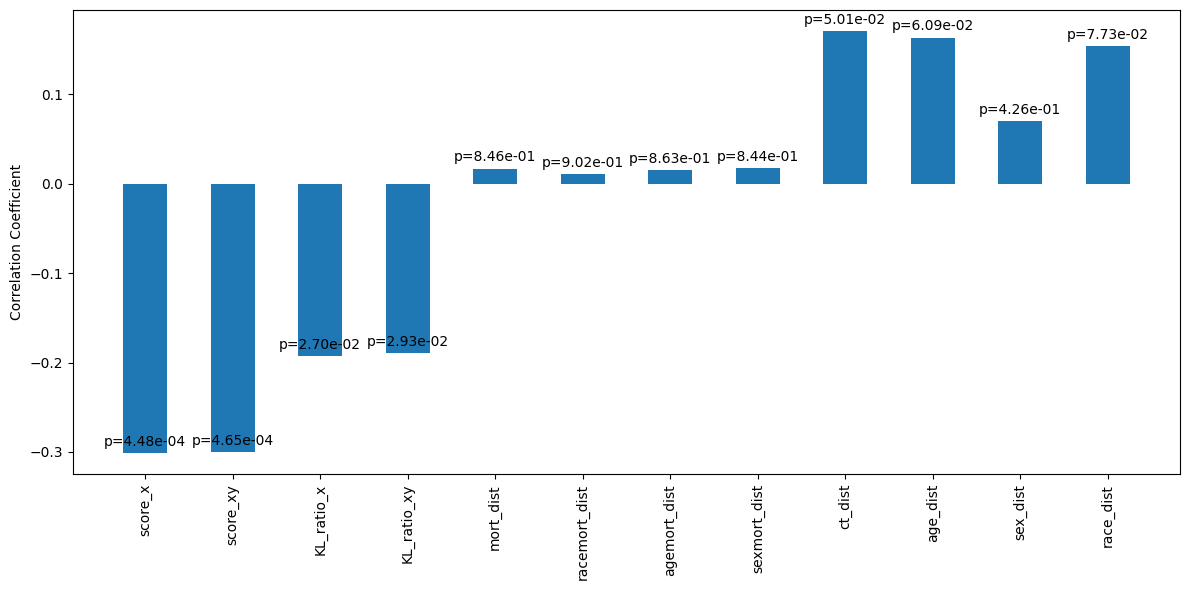

In [18]:
# List of columns to compute correlation with 'LR'
cols = ['score_x', 'score_xy', 'KL_ratio_x', 'KL_ratio_xy', 'mort_dist', 
        'racemort_dist', 'agemort_dist', 'sexmort_dist', 'ct_dist', 
        'age_dist', 'sex_dist', 'race_dist']

# Compute correlation coefficients and p-values
corr_coefs = []
p_values = []
for col in cols:
    corr_coef, p_val = pearsonr(plot_df['LR'], plot_df[col])
    corr_coefs.append(corr_coef)
    p_values.append(p_val)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bar_width = 0.5
bar_positions = np.arange(len(corr_coefs))
bars = ax.bar(bar_positions, corr_coefs, bar_width, align='center')

# Add column names as x-tick labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(cols, rotation=90)

# Add y-axis label
ax.set_ylabel('Correlation Coefficient')

# Add p-values above each bar
for bar, p_val in zip(bars, p_values):
    height = bar.get_height()
    ax.annotate(f'p={p_val:.2e}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Section 4: Data Addition

In [77]:
hos=443
# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
hos_ind = hospital_dict[hos]
model = "LogisticRegression"
n_avg = np.load(f"results/sequential-n/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz", allow_pickle=True)
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz", allow_pickle=True)
sequential_best_avg = np.load(f"results/sequential-n/{hos}-{model}-best-hospitals-avg.npz", allow_pickle=True)
sequential_best_std = np.load(f"results/sequential-n/{hos}-{model}-best-hospitals-std.npz", allow_pickle=True)
sequential_worst_avg = np.load(f"results/sequential-n/{hos}-{model}-worst-hospitals-avg.npz", allow_pickle=True)
sequential_worst_std = np.load(f"results/sequential-n/{hos}-{model}-worst-hospitals-std.npz", allow_pickle=True)
mixture_avg = np.load(f"results/sequential-n/{hos}-mixture-{model}-avg.npz", allow_pickle=True)
mixture_std = np.load(f"results/sequential-n/{hos}-mixture-{model}-std.npz", allow_pickle=True)


In [78]:
plot_df = pd.DataFrame.from_dict(n_avg['AUC'].item(), orient='index', columns=['AUC'])
std_df = pd.DataFrame.from_dict(n_std['AUC'].item(), orient='index', columns=['std'])

plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

In [79]:
best_df = pd.DataFrame.from_dict(sequential_best_avg['AUC'].item(), orient='index', columns=['Best3-AUC'])
worst_df = pd.DataFrame.from_dict(sequential_worst_avg['AUC'].item(), orient='index', columns=['Worst3-AUC'])
mixture_df = pd.DataFrame.from_dict(mixture_avg['AUC'].item(), orient='index', columns=['Mixture-AUC'])
best_df_std = pd.DataFrame.from_dict(sequential_best_std['AUC'].item(), orient='index', columns=['Best3-std'])
worst_df_std = pd.DataFrame.from_dict(sequential_worst_std['AUC'].item(), orient='index', columns=['Worst3-std'])
mixture_df_std = pd.DataFrame.from_dict(mixture_std['AUC'].item(), orient='index', columns=['Mixture-std'])
plot_df = pd.concat([best_df, worst_df, mixture_df, best_df_std, worst_df_std, mixture_df_std], axis=1)
addition_df = plot_df.reset_index(names='n')

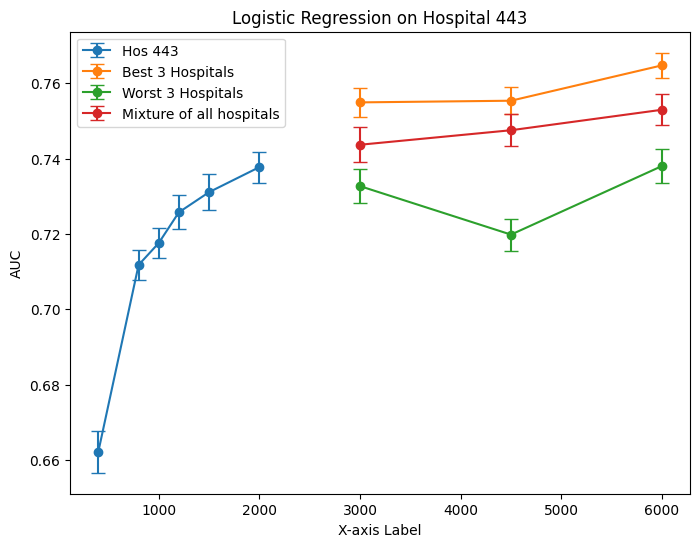

In [80]:
sem_ratio = np.sqrt(5)
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars

hos_df = new_df
ax.errorbar(x=hos_df['n'],
            y=hos_df['AUC'],
            yerr=[hos_df['std']/sem_ratio ,hos_df['std']/sem_ratio],
            fmt='o-',
            capsize=5,
            label=f'Hos {hos}')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Best3-AUC'],
            yerr=[addition_df['Best3-std']/sem_ratio ,addition_df['Best3-std']/sem_ratio],
            fmt='o-',
            capsize=5,
            label=f'Best 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Worst3-AUC'],
            yerr=[addition_df['Worst3-std']/sem_ratio ,addition_df['Worst3-std']/sem_ratio],
            fmt='o-',
            capsize=5,
            label=f'Worst 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Mixture-AUC'],
            yerr=[addition_df['Mixture-std']/sem_ratio ,addition_df['Mixture-std']/sem_ratio],
            fmt='o-',
            capsize=5,
            label=f'Mixture of all hospitals')

# Set labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('AUC')
ax.set_title(f'Logistic Regression on Hospital {hos}')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
# TODOS: 
- capped Shift LSTM add data
- capped addition (LSTM running / LR, LGBM need to be loaded)
- Hosp 199 (by score heuristic) LogReg x {Sequential, Mixture}

- Hosp 433 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}
- Hosp 199 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}

- Hosp 443 (by ground truth) -> LogReg x {Sequential, Mixture}
